# Initializations

In [1]:
import numpy as np
import pandas as pd

import sys, os, time
import glob

from matplotlib import pyplot as plt
%matplotlib inline

# these magics ensure that external modules that are modified are also automatically reloaded
%load_ext autoreload
%autoreload 2

# widgets and interaction
from ipywidgets import FloatProgress
from IPython.display import display, clear_output

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

from skimage.io import imread, imsave

import warnings
warnings.filterwarnings('ignore')

import gzip
import cPickle as pickle

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.utils as vutils
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable

import sys
sys.path.append("../models/")

import models.dcgan as dcgan
import models.mlp as mlp
import models.dcgan_orig as do

# Train GAN
We could spawn external process, but better just copy the command into an external script and run in a separate terminal. 

In [4]:
dataroot = "/home/data/world-cities/"

nz   = 100
ngf  = 16
ndf  = 16
nc   = 1
imageSize = 64
batchSize = 64
workers   = 4
val_nodata = 128
classCol = "decile"
ncond = 1 # number of stats or other conditions

beta1 = 0.5
lr = 0.0002

ngpu = 4
n_extra_layers = 0

In [5]:
train_df = pd.read_csv(dataroot + "train-2pct.csv")
print len(train_df)

17300


In [6]:
# img_smpl = np.array([imread(f) for f in train_df.sample(1000)['filename']])

# mu, std = img_smpl.mean(), img_smpl.std()
# mu, std

In [62]:
def compute_stats(batch):
    return batch.abs().mean(2).mean(3)

from skimage import morphology
from skimage.transform import resize

def compute_patch_areas(M):
    mask = morphology.label(M)
    areas = []
    for i in np.arange(1,mask.max()):
        areas.append((i,(mask==i).sum()))
    areas.sort(key=lambda x: x[1], reverse=True)
    return areas, mask

In [65]:
areas, mask = compute_patch_areas(resize(np.array(img),(imageSize,imageSize)))

In [70]:
areas

[(10, 21),
 (12, 5),
 (4, 4),
 (5, 4),
 (16, 4),
 (6, 2),
 (20, 2),
 (22, 2),
 (1, 1),
 (2, 1),
 (3, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (11, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (17, 1),
 (18, 1),
 (19, 1),
 (21, 1)]

areas

In [53]:
compute_patch_areas(img)

AttributeError: 'Image' object has no attribute 'shape'

#### Set up batching

In [42]:
import sys
sys.path.append("./../models/pytorch_utils")
from loader_dataframe import ImageDataFrame, grayscale_loader, WeightedRandomSampler

from PIL import Image

def fn_rotate(img):
    theta = np.random.randn()*180
    return img.rotate(theta, expand=True)

pxCrop = 448

dataset = ImageDataFrame(df=train_df, 
                         classCol=classCol,
                         loader=grayscale_loader,
                         transform=transforms.Compose([
                               transforms.RandomHorizontalFlip(),
                               # transforms.RandomCrop(pxCrop),
                               transforms.CenterCrop(pxCrop),
                               transforms.Lambda(lambda img: fn_rotate(img)),
                               transforms.Scale(imageSize),
                               transforms.ToTensor(),
                               # transforms.Normalize((mu, mu, mu), (std, std, std)),
                           ]))
n_classes = len(dataset.classes)
train_df['']
weights = train_df['built pct']

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize,
                                         shuffle=True, 
                                         sampler=WeightedRandomSampler(weights, len(train_df)),
                                         num_workers=int(workers))

In [46]:
train_df['decile'].value_counts()

9    2499
7    2499
5    2499
8    2498
6    2498
4    2497
3    2310
Name: decile, dtype: int64

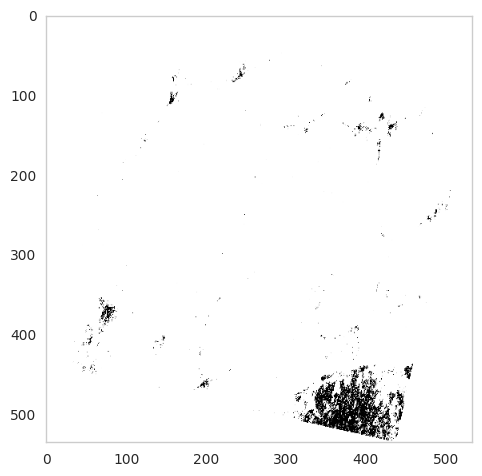

In [43]:
img = grayscale_loader(train_df['filename'].iloc[0])
plt.imshow(fn_rotate(img))

In [44]:
for data in dataloader:
    img_batch, _ = data
    img_batch_np = img_batch.numpy()
    stats = compute_stats(img_batch)
    break

(array([ 5.,  5.,  4.,  4.,  4.,  6.,  7.,  9.,  3.,  5.,  2.,  2.,  2.,
         0.,  2.,  1.,  0.,  1.,  1.,  1.]),
 array([ 0.00751474,  0.01409721,  0.02067967,  0.02726213,  0.03384459,
         0.04042705,  0.04700952,  0.05359198,  0.06017444,  0.0667569 ,
         0.07333937,  0.07992183,  0.08650429,  0.09308675,  0.09966921,
         0.10625168,  0.11283414,  0.1194166 ,  0.12599906,  0.13258152,
         0.13916399]),
 <a list of 20 Patch objects>)

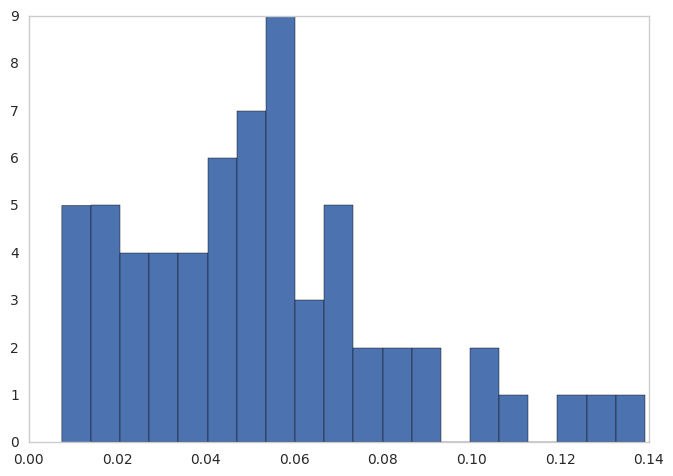

In [45]:
plt.hist(stats.numpy().squeeze(), bins=20)

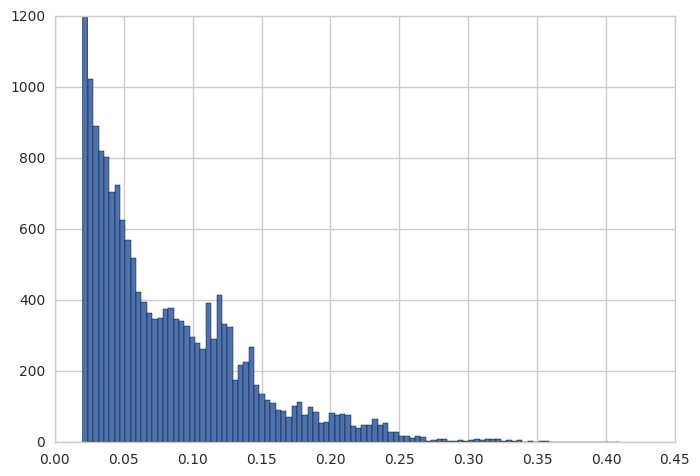

In [14]:
train_df['built pct'].hist(bins=100)

#### Set up models

In [47]:
netD_ckpt = '' # "/home/nbserver/pytorch-workspace/DCGAN/16-weak-cond/"
netG_ckpt = '' # "/home/nbserver/pytorch-workspace/DCGAN/16-weak-cond/"

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

# initialize generator
netG = do._netG(ngpu, nc, nz + ncond, ngf)
netG.apply(weights_init)
if netG_ckpt != '':
    netG.load_state_dict(torch.load(netG_ckpt))
print(netG)

# initialize discriminator
netD = do._netD(ngpu, nc, ndf, n_classes=n_classes+1) # number of classes + fake/real
netD.apply(weights_init)
if netD_ckpt != '':
    netD.load_state_dict(torch.load(netD_ckpt))
print(netD)


_netG (
  (main): Sequential (
    (0): ConvTranspose2d(101, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU (inplace)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU (inplace)
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (8): ReLU (inplace)
    (9): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
    (11): ReLU (inplace)
    (12): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh ()
  )
)
_netD (
  (main): Sequential (
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): L

In [ ]:
nn.parallel.data_parallel()

#### Set up optimization

In [48]:
criterion = nn.BCELoss()
penalty_MSE = torch.nn.MSELoss()
penalty_CEL = torch.nn.CrossEntropyLoss()

input = torch.FloatTensor(batchSize, nc, imageSize, imageSize)
noise = torch.FloatTensor(batchSize, nz, 1, 1)
fixed_noise = torch.FloatTensor(batchSize, nz, 1, 1).normal_(0, 1)
fixed_cond  = torch.FloatTensor(batchSize, 1, 1, 1)
fixed_cond.fill_(0.05)
label = torch.FloatTensor(batchSize)
target= torch.FloatTensor(batchSize, len(dataset.classes), 1, 1)
real_label = 1
fake_label = 0

if torch.cuda.is_available():
    netD.cuda()
    netG.cuda()
    criterion.cuda()
    penalty_MSE.cuda()
    penalty_CEL.cuda()
    input, label, target = input.cuda(), label.cuda(), target.cuda()
    noise, fixed_noise, fixed_cond = noise.cuda(), fixed_noise.cuda(), fixed_cond.cuda()

input = Variable(input)
label = Variable(label)
noise = Variable(noise)
target= Variable(target)

fixed_noise = Variable(fixed_noise)
fixed_cond  = Variable(fixed_cond)

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr = lr, betas = (beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr = lr, betas = (beta1, 0.999))

#### Train

In [49]:
outf = "/home/data/pytorch-workspace/DCGAN/16-weak-cond-2pct-6/"
try:
    os.makedirs(outf)
except OSError:
    pass

niter = 50
lamD  = 50 #10 # hyperparameter for tradeoff between objectives
lamG  = 1000 #10 # hyperparameter for tradeoff between objectives

lossED = []
lossEG = []
lossD = []
lossG = []
for epoch in range(niter):
    lossD_epoch = []
    lossG_epoch = []
    lossED_epoch = []
    lossEG_epoch = []
    for i, data in enumerate(dataloader, 0):

        clear_output(wait=True)
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        
        real_cpu, target_cpu = data
        batch_size = real_cpu.size(0)
                
        input.data.resize_(real_cpu.size()).copy_(real_cpu)
        target.data.resize_(target_cpu.size()).copy_(target_cpu)

        # compute stats on real images
        stats_real = compute_stats(input).detach() # just stats on input data, nothing to optimize here, so detach from computational graph

        # forward pass in G
        noise.data.resize_(batch_size, nz, 1, 1)
        noise.data.normal_(0, 1) 
        conditions = stats_real
        fake = netG(noise, cond=conditions)
        
        # compute stats on fake images
        stats_fake = compute_stats(fake)
        # err_stats = ((stats_fake - stats_real).abs()).mean() # lam can be a vector when more stats are used
        err_stats = ((stats_fake - stats_real)**2).max() # / (stats_real**2).mean() # lam can be a vector when more stats are used
        # err_stats = penalty_MSE(stats_fake, stats_real)
        
        # train with real
        netD.zero_grad()
        output = netD(input)
        label.data.resize_(batch_size).fill_(real_label)
        errD_real = criterion(output, label) 
        errD_real.backward(retain_variables=True)
        D_x = output.data.mean()
        
        # train with fake   
        label.data.fill_(fake_label)
        output = netD(fake.detach())        
        penaltyD = lamD * err_stats
        errD_fake = criterion(output, label) + penaltyD
        errD_fake.backward(retain_variables=True)
        D_G_z1 = output.data.mean()
        errD = errD_real + errD_fake
        
        # errD.backward()
        optimizerD.step()
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ########################### 
        
        netG.zero_grad()
        label.data.fill_(real_label) # fake labels are real for generator cost
        output = netD(fake)
        targets= stats_fake.resize(batch_size).detach()
        penaltyG = lamG * err_stats
        errG = criterion(output, label) + penaltyG
        errG.backward()
        D_G_z2 = output.data.mean()
        optimizerG.step()

        lossEG_epoch.append(penaltyG.data[0])
        lossED_epoch.append(penaltyD.data[0])
        lossD_epoch.append(errD.data[0])
        lossG_epoch.append(errG.data[0])
        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f Penalty D: %.4f Penalty G: %.4f Penalty/Loss (D): %.4f Penalty/Loss (G): %.4f '
              % (epoch, niter, i, len(dataloader),
                 errD.data[0], errG.data[0], D_x, D_G_z1, D_G_z2, 
                 penaltyD.mean().data[0], penaltyG.mean().data[0], 
                 errD.data[0] / penaltyD.mean().data[0], errG.data[0] / penaltyG.mean().data[0]))
        if i % 100 == 0:
            vutils.save_image(real_cpu,
                    '%s/real_samples.png' % outf)
            fake = netG(fixed_noise, cond=fixed_cond)
            vutils.save_image(fake.data,
                    '%s/fake_samples_epoch_%03d.png' % (outf, epoch))

    # save plot of losses for G and D
    lossED.append((np.mean(lossED_epoch), np.std(lossED_epoch)))
    lossEG.append((np.mean(lossEG_epoch), np.std(lossEG_epoch)))
    lossD.append((np.mean(lossD_epoch), np.std(lossD_epoch)))
    lossG.append((np.mean(lossG_epoch), np.std(lossG_epoch)))

    with gzip.open(outf + "/training-loss.pickle.gz", "w") as f:
        pickle.dump([lossD, lossG, lossED, lossEG], f)

    # plt.ioff()
    fig = plt.figure()
    plt.errorbar(range(len(lossD)), [x[0] for x in lossD], 
        yerr=[x[1] for x in lossD], label="D loss")
    plt.errorbar(range(len(lossG)), [x[0] for x in lossG], 
        yerr=[x[1] for x in lossG], label="G loss")
    plt.legend(loc="best")
    plt.title("DCGAN training on SAR urban patches")
    plt.savefig("%s/training_progress.jpg"%outf)
    plt.close(fig)

    # do checkpointing
    torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (outf, epoch))
    torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (outf, epoch))


[49/50][270/271] Loss_D: 1.3652 Loss_G: 3.3043 D(x): 0.4369 D(G(z)): 0.0408 / 0.2473 Penalty D: 0.0591 Penalty G: 1.1820 Penalty/Loss (D): 23.0984 Penalty/Loss (G): 2.7954 


In [ ]:
output.size()

In [ ]:
input.size()

In [ ]:
noise_np = noise.data.cpu().numpy().squeeze()

In [ ]:
conditions.data.cpu().numpy().squeeze()

In [ ]:
Z = torch.cat([noise, conditions], 1)

In [ ]:
Z_np = Z.data.cpu().numpy().squeeze()
Z_np.shape

In [ ]:
fake1 = netG(Z)

In [ ]:
fake1.abs().mean(2).mean(3).data.cpu().numpy().squeeze()

In [ ]:
stats_fake.data.cpu().numpy().squeeze()

In [ ]:
print ((stats_fake - stats_real).abs()).mean() 
print ((stats_fake - stats_real)**2).mean() 


In [ ]:
errD, errG, err_stats*lam

In [ ]:
stats_real_np = stats_fake.data.cpu().numpy().squeeze()
stats_fake_np = stats_real.data.cpu().numpy().squeeze()

In [ ]:
np.vstack([stats_real_np, stats_fake_np]).T

In [ ]:
fig, ax = plt.subplots()
ax.scatter(stats_real_np, stats_fake_np)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

# Plot fake and real samples

In [ ]:
# experiment_dir = "/home/adalbert/nbserver/pytorch-workspace/DCGAN/25k-cities-128/"

experiment_dir = outf

In [ ]:
files_fake = glob.glob(experiment_dir + "/fake*.png")
files_fake.sort(key=lambda x: int(os.path.basename(x).split("_")[-1].replace(".png","")))

files_real = glob.glob(experiment_dir + "/real*.png")

img_real = imread(files_real[0])
img_real = img_real / float(img_real.max())
plt.imshow(1-np.abs(img_real))
plt.title("Real Samples")
plt.axis("off")
plt.show()

for f in files_fake[-5:]:
    img = imread(f)
    img = img / float(img.max())
    plt.imshow(1 - np.abs(img))
    plt.title(os.path.basename(f))
    plt.axis("off")
    plt.show()


In [ ]:
import cPickle as pickle
import gzip

with gzip.open(experiment_dir + "./training-loss.pickle.gz", "r") as f:
    lossD, lossG = pickle.load(f)
    
lossD = np.array(lossD)
lossG = np.array(lossG)

# plot
fig,ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(lossD[:,0], label="D loss")
ax[0].legend()
ax[1].plot(lossG[:,0], label="G loss")
ax[1].legend()